## Data Handling

In [14]:
from sklearn.datasets import load_iris

iris_data = load_iris()

In [15]:
from sklearn.datasets import load_digits
import pandas as pd


digit_data = load_digits()


df = pd.DataFrame(digit_data.data, columns=digit_data.feature_names)
df["class"] = pd.Series(digit_data.target)

#sns.pairplot(df, hue="class", palette="tab10")
#df = pd.DataFrame(digit_data.data, columns=digit_data.feature_names)
df.shape

(1797, 65)

In [2]:
print(iris_data.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [3]:
features = iris_data.data
labels = iris_data.target

In [4]:
from sklearn.preprocessing import MinMaxScaler

features = MinMaxScaler().fit_transform(features)

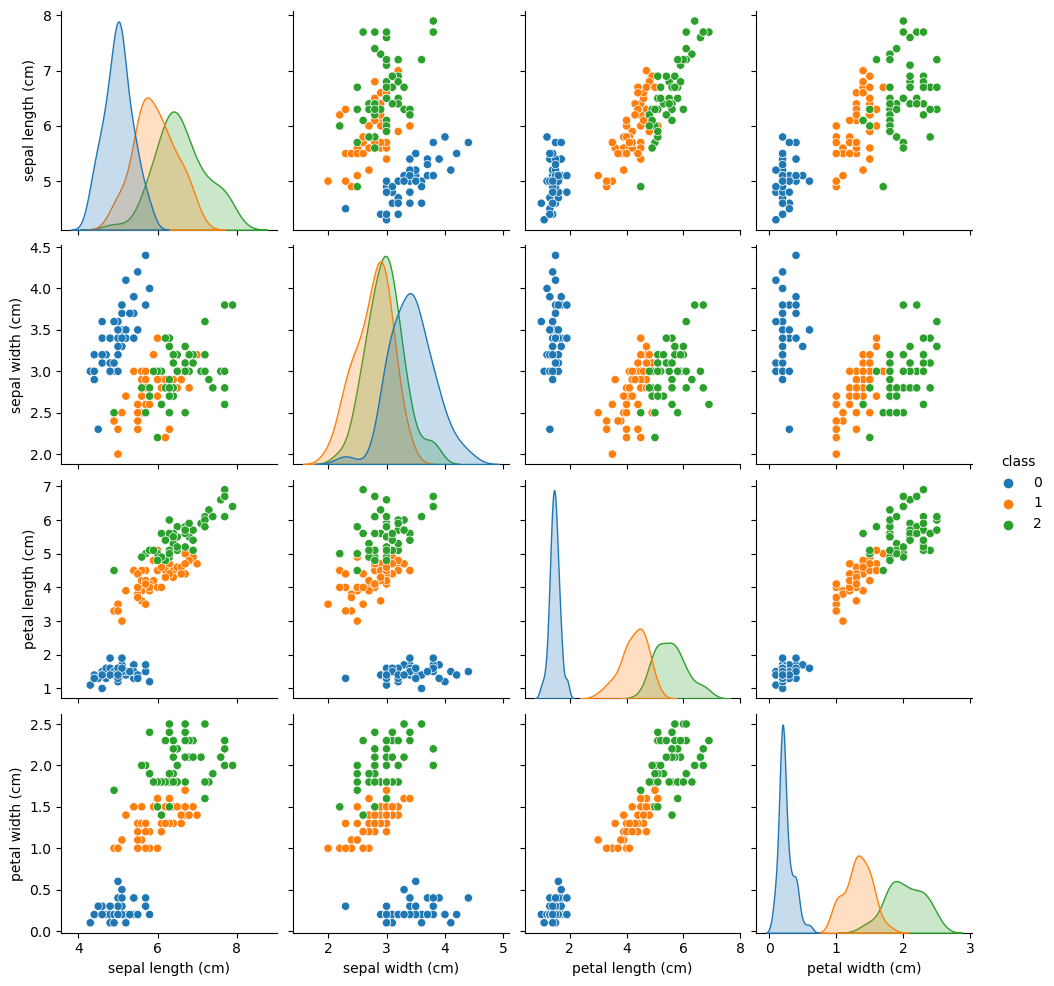

In [8]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(iris_data.data, columns=iris_data.feature_names)
df["class"] = pd.Series(iris_data.target)

sns.pairplot(df, hue="class", palette="tab10")

## Classical Machine Learning Approach

In [9]:
from sklearn.model_selection import train_test_split
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 123
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)

In [10]:
from sklearn.svm import SVC

svc = SVC()
_ = svc.fit(train_features, train_labels)  # suppress printing the return value

In [11]:
train_score_c4 = svc.score(train_features, train_labels)
test_score_c4 = svc.score(test_features, test_labels)

print(f"Classical SVC on the training dataset: {train_score_c4:.2f}")
print(f"Classical SVC on the test dataset:     {test_score_c4:.2f}")

Classical SVC on the training dataset: 0.99
Classical SVC on the test dataset:     0.97


## VQC (Variational Quantum Classifier) Approach

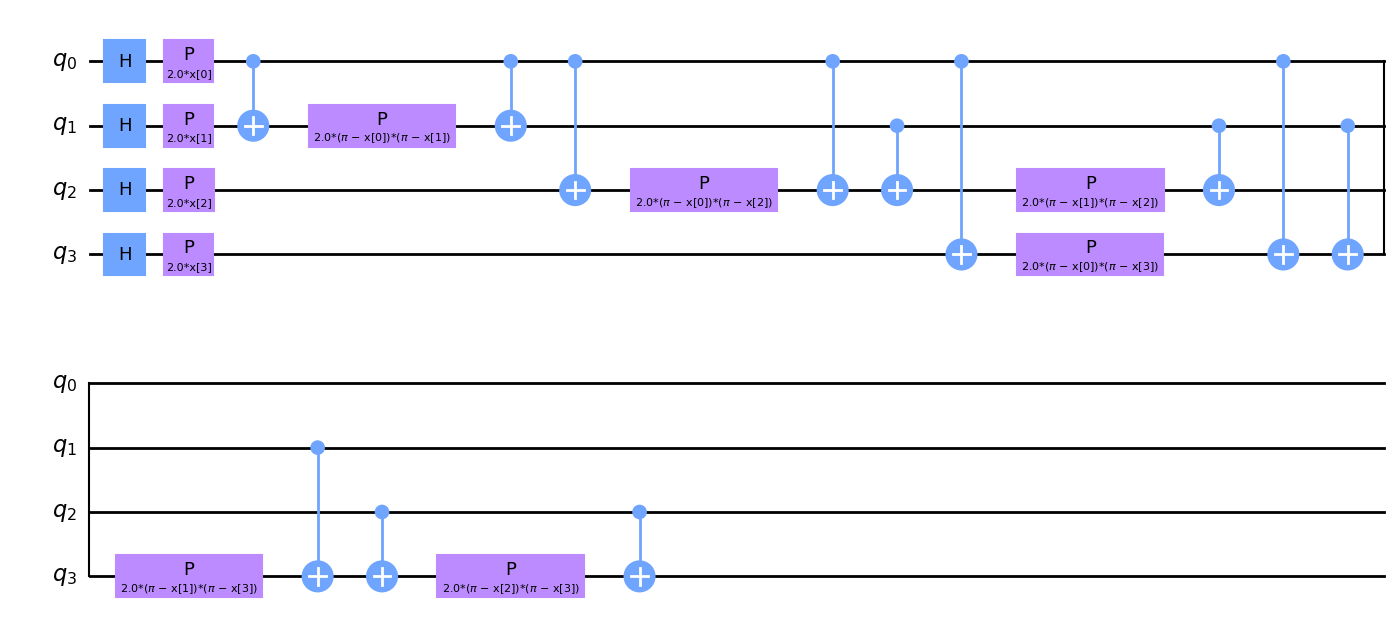

In [9]:
from qiskit.circuit.library import ZZFeatureMap

num_features = features.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw(output="mpl", fold=20)

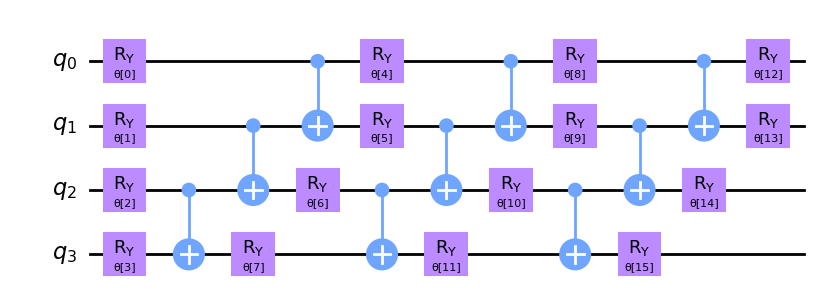

In [10]:
from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
ansatz.decompose().draw(output="mpl", fold=20)

In [11]:
from qiskit.algorithms.optimizers import COBYLA

optimizer = COBYLA(maxiter=100)

In [12]:
from qiskit.primitives import Sampler

sampler = Sampler()

In [13]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

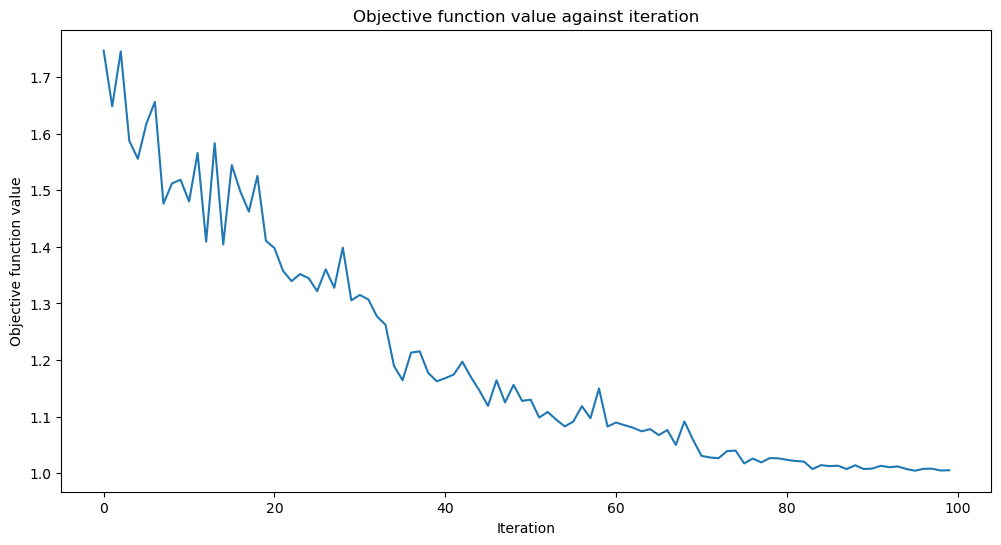

Training time: 348 seconds


In [14]:
import time
from qiskit_machine_learning.algorithms.classifiers import VQC

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [15]:
train_score_q4 = vqc.score(train_features, train_labels)
test_score_q4 = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")

Quantum VQC on the training dataset: 0.85
Quantum VQC on the test dataset:     0.87


## QSVC (Quantum Support Vector Classifier) Approach

In [12]:
import numpy as np

def data_map_eq12(x: np.ndarray) -> float:
    coeff = x[0] if len(x) == 1 else reduce(lambda m, n: np.pi*(m * n), np.cos(x))
    return coeff

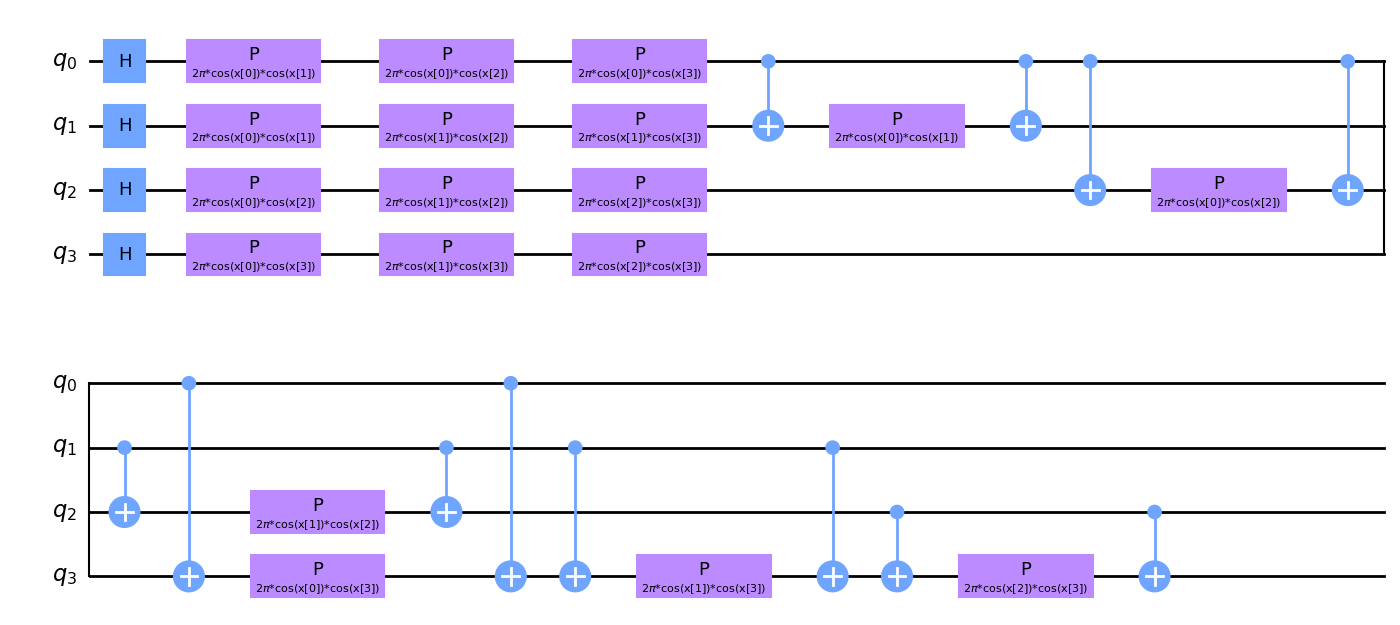

In [13]:
from qiskit.circuit.library import PauliFeatureMap
from functools import reduce

num_features = features.shape[1]

feature_map = PauliFeatureMap(feature_dimension=num_features, 
                              paulis = ['ZI','IZ','ZZ'],
                              reps=1, 
                              entanglement='full', 
                              data_map_func=data_map_eq12)
feature_map.decompose().draw(output="mpl", fold=20)


In [18]:
from qiskit.primitives import Sampler

sampler = Sampler()

In [19]:
from qiskit import Aer
from qiskit.algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel

import time
from qiskit_machine_learning.algorithms.classifiers import QSVC

fidelity = ComputeUncompute(sampler=sampler)
kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)

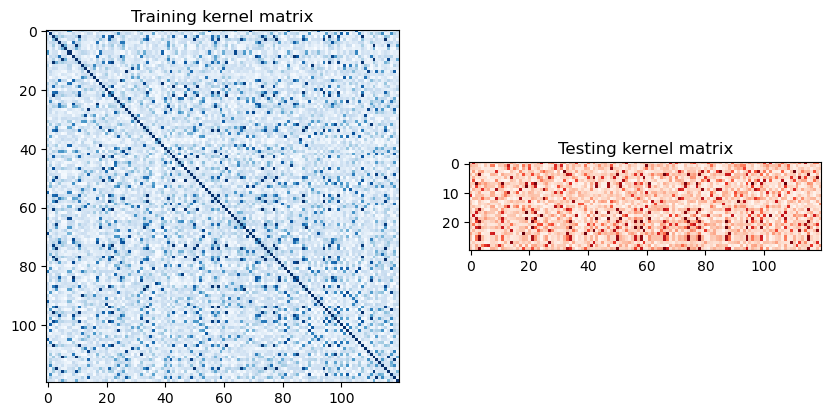

In [20]:
fidelity = ComputeUncompute(sampler=sampler)
kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)
matrix_train = kernel.evaluate(x_vec=train_features)
matrix_test = kernel.evaluate(x_vec=test_features, y_vec=train_features)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(
    np.asmatrix(matrix_train), interpolation="nearest", origin="upper", cmap="Blues"
)
axs[0].set_title("Training kernel matrix")
axs[1].imshow(np.asmatrix(matrix_test), interpolation="nearest", origin="upper", cmap="Reds")
axs[1].set_title("Testing kernel matrix")
plt.show()

In [21]:
# Initialize QSVC algorithm
qsvc = QSVC(quantum_kernel=kernel)

# clear objective value history
objective_func_vals = []

start = time.time()
qsvc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

Training time: 129 seconds


In [22]:
train_score_q4 = qsvc.score(train_features, train_labels)
test_score_q4 = qsvc.score(test_features, test_labels)

print(f"Quantum QSVC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum QSVC on the test dataset:     {test_score_q4:.2f}")

Quantum QSVC on the training dataset: 0.97
Quantum QSVC on the test dataset:     0.90
